#  Policy Gradients

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Саттон Р. С., Барто Э. Дж. Обучение с подкреплением: Введение. 2-е изд.
* Лю Ю. (Х.) Обучение с подкреплением на PyTorch: сборник рецептов / пер. с англ. А. А. Слинкина. – М.: ДМК Пресс, 2020
* https://www.youtube.com/watch?v=_x0ASf9jV9U&ab_channel=sim0nsays
* https://karpathy.github.io/2016/05/31/rl/
* https://neerc.ifmo.ru/wiki/index.php?title=%D0%9C%D0%B5%D1%82%D0%BE%D0%B4%D1%8B_policy_gradient_%D0%B8_%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%B0%D1%81%D0%B8%D0%BD%D1%85%D1%80%D0%BE%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE_%D0%B0%D0%BA%D1%82%D0%BE%D1%80%D0%B0-%D0%BA%D1%80%D0%B8%D1%82%D0%B8%D0%BA%D0%B0
* https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html
* https://huggingface.co/learn/deep-rl-course/unit4/introduction
* https://lilianweng.github.io/posts/2018-04-08-policy-gradient/#:~:text=The%20goal%20of%20reinforcement%20learning,and%20optimizing%20the%20policy%20directly.

## Задачи для совместного разбора

1\. Рассмотрите основные шаги по формированию обучающей выборки для использования алгоритмов Policy Gradients.

In [ ]:
import torch as th

In [ ]:
state_dim = 5
n_action = 3

state = th.rand(state_dim)
state

tensor([0.4931, 0.2979, 0.4382, 0.2791, 0.0938])

In [ ]:
import torch.nn as nn

In [ ]:
model = nn.Sequential(
    nn.Linear(state_dim, n_action),
    nn.Softmax()
)

In [ ]:
prediction = model(state)
prediction

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([0.2995, 0.2119, 0.4887], grad_fn=<SoftmaxBackward0>)

In [ ]:
state_ = th.rand((3,5))
prediction_ = model(state_)
th.multinomial(prediction_, 2)

tensor([[2, 0],
        [1, 0],
        [2, 1]])

In [ ]:
action = th.multinomial(prediction, 1).item()
action

2

In [ ]:
log_prob = prediction[action].log()
log_prob

tensor(-0.7161, grad_fn=<LogBackward0>)

In [ ]:
th.rand(1)

tensor([0.7321])

In [ ]:
log_probs = []
rewards = []

state = th.rand(state_dim) # reset
for _ in range(10):
  # ... env.step()
  prediction = model(state)
  action = th.multinomial(prediction, 1).item()
  log_prob = prediction[action].log()
  r = th.rand(1)

  log_probs.append(log_prob)
  rewards.append(r.item())

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [ ]:
log_probs

[tensor(-1.0952, grad_fn=<LogBackward0>),
 tensor(-1.0952, grad_fn=<LogBackward0>),
 tensor(-0.9927, grad_fn=<LogBackward0>),
 tensor(-1.2209, grad_fn=<LogBackward0>),
 tensor(-1.2209, grad_fn=<LogBackward0>),
 tensor(-0.9927, grad_fn=<LogBackward0>),
 tensor(-1.0952, grad_fn=<LogBackward0>),
 tensor(-1.0952, grad_fn=<LogBackward0>),
 tensor(-0.9927, grad_fn=<LogBackward0>),
 tensor(-1.2209, grad_fn=<LogBackward0>)]

In [ ]:
rewards # r

[0.3319135308265686,
 0.35195595026016235,
 0.6651511192321777,
 0.8631353378295898,
 0.042236268520355225,
 0.1988416314125061,
 0.5230377912521362,
 0.379170298576355,
 0.7268886566162109,
 0.1322454810142517]

In [ ]:
len(rewards)

10

In [ ]:
gamma = 0.99
R[9] = 0.1322454810142517
R[8] = 0.7268886566162109 + gamma* 0.1322454810142517
# ...

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Допишите классы `Policy` для реализации модели политики и `Trainer` для реализации процесса обучения модели при помощи алгоритма REINFORCE. Настройте агента для игры в окружении `CartPole-v1`. Визуализируйте динамику значений награды на эпизод в процессе обучения. Сыграйте эпизод, используя обученного агента, и убедитесь, что агент выучивается, как стабилизировать шест.

$$L_{PG} = -\sum_{i}{R_i\log{p(a_i|s_i)}}$$

$$R_t = \sum_{k=0}^{\infty}\gamma^kr_{t+k}$$

где $r_t$ - награда за шаг $t$.


- [ ] Проверено на семинаре

In [1]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 5.4 MB/s eta 0:00:00


In [2]:
import torch as th
import torch
import gymnasium as gym
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from gymnasium import wrappers
from dataclasses import dataclass
import numpy as np

In [3]:
from dataclasses import dataclass
@dataclass
class PolicyConfig:
    n_state: int
    n_action: int
    n_hidden: int

In [4]:
class PolicyNetwork(nn.Module):
    def __init__(self, policy_config: PolicyConfig, device='cpu'):
        super().__init__()
        self.cfg = policy_config
        self.model = nn.Sequential(nn.Linear(policy_config.n_state, policy_config.n_hidden),
                                   nn.ReLU(),
                                   nn.Linear(policy_config.n_hidden, policy_config.n_action),
                                   nn.Softmax())
        self.device = device

    def forward(self, s: th.Tensor) -> th.Tensor:
        return self.model(s)

    def get_action(self, s: th.Tensor) -> tuple[int, float]:
        # возвращает действие пропорционально вероятностям, полученным при помощи модели
        # и логарифм вероятности выбранного действия
        probs = self.forward(s)
        action = th.multinomial(probs, 1).item()
        log_prob = probs[action].log()
        return action, log_prob

In [5]:
from dataclasses import dataclass

@dataclass
class TrainConfig:
    gamma: float = 0.99
    learning_rate: float = 0.001
    episode_num: float = 400

In [6]:
class Trainer:
  def __init__(self, policy_net, train_config):
    self.policy_net = policy_net.to(policy_net.device)
    self.gamma = train_config.gamma
    self.learning_rate = train_config.learning_rate
    self.episode_num = train_config.episode_num

  def get_episode(self, env):
    episode = []
    state = env.reset()[0]
    while True:
      state = torch.FloatTensor(state).to(self.policy_net.device)
      action, log_prob = self.policy_net.get_action(state)
      next_state, reward, terminated, truncated, _ = env.step(action)
      episode.append((state, action, reward))
      state = next_state
      if terminated or truncated:
        break
    return episode

  def train(self, env):
    optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
    self.episode_rewards = []

    for i in range(self.episode_num+1):
      policy_loss = 0
      episode = self.get_episode(env)
      total_reward = 0

      for t in range(len(episode)):
        # print(episode)
        state, action, reward = episode[t]
        action_taken, log_prob = self.policy_net.get_action(state)
        R = np.sum([rew * (self.gamma ** i) for i, (_,_,rew)  in enumerate(episode[t:])])
        policy_loss -= log_prob * R
        total_reward += reward
      self.episode_rewards.append(total_reward)

      optimizer.zero_grad()
      policy_loss.backward()
      optimizer.step()

      if i % 50 == 0:
        print(f'Epoch_{i}: mean reward = {np.mean(self.episode_rewards[-50:])}')

In [34]:
env = gym.make('CartPole-v1')
n_obs = env.observation_space.shape[0]
n_acts = env.action_space.n

policy_config = PolicyConfig(n_obs, n_acts, 1000)
train_config = TrainConfig(0.99, 1e-4, 400)

policy_net = PolicyNetwork(policy_config, device='cuda')
trainer = Trainer(policy_net, train_config)
trainer.train(env)

Epoch_0: mean reward = 17.0
Epoch_50: mean reward = 21.98
Epoch_100: mean reward = 26.92
Epoch_150: mean reward = 22.58
Epoch_200: mean reward = 25.2
Epoch_250: mean reward = 31.88
Epoch_300: mean reward = 29.52
Epoch_350: mean reward = 32.36
Epoch_400: mean reward = 29.9


In [24]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import pandas as pd

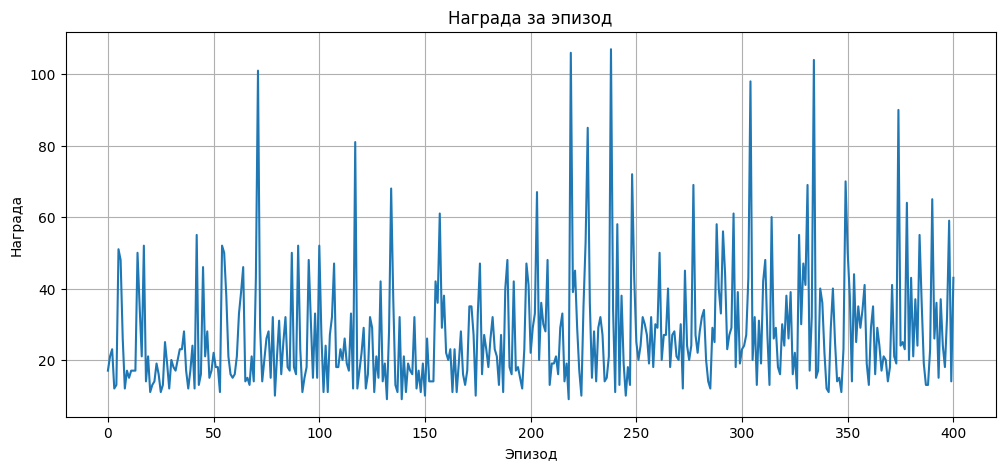

In [35]:
fig = plt.figure(figsize=(12,5))
plt.plot(trainer.episode_rewards)
plt.title('Награда за эпизод')
plt.xlabel('Эпизод')
plt.ylabel('Награда')
plt.grid()

In [11]:
import pandas as pd

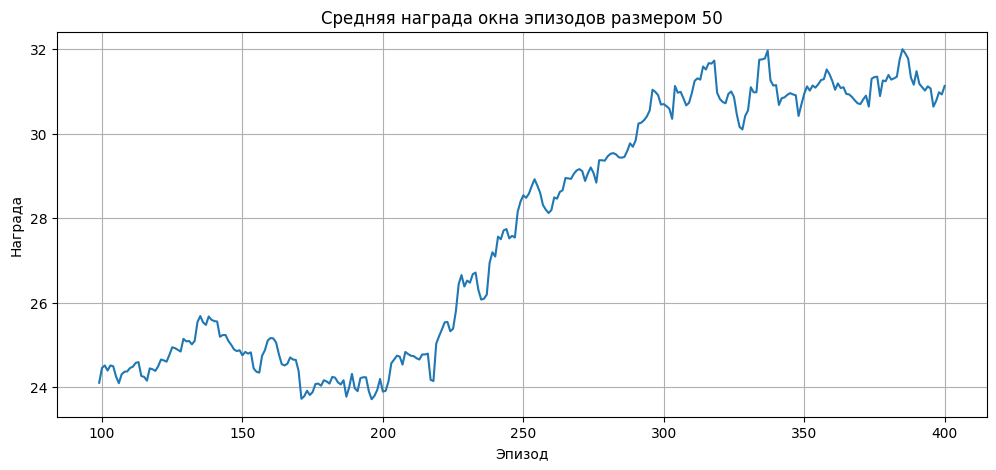

In [36]:
fig = plt.figure(figsize=(12,5))
df = pd.DataFrame(trainer.episode_rewards)

plt.title('Средняя награда окна эпизодов размером 50')
plt.plot(df.rolling(window=100).mean())
plt.xlabel('Эпизод')
plt.ylabel('Награда')
plt.grid()

In [39]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
env = wrappers.RecordVideo(env, './videos')
state = env.reset()[0]
total_reward = 0

while True:
  env.render()
  action, _ = policy_net.get_action(torch.FloatTensor(state).to('cuda'))
  next_state, reward, terminated, truncated, _ = env.step(action)
  total_reward += reward
  state = next_state

  if terminated or truncated:
    break

print(f"Награда: {total_reward}")
env.close()

Moviepy - Building video /content/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-0.mp4
Награда: 38.0


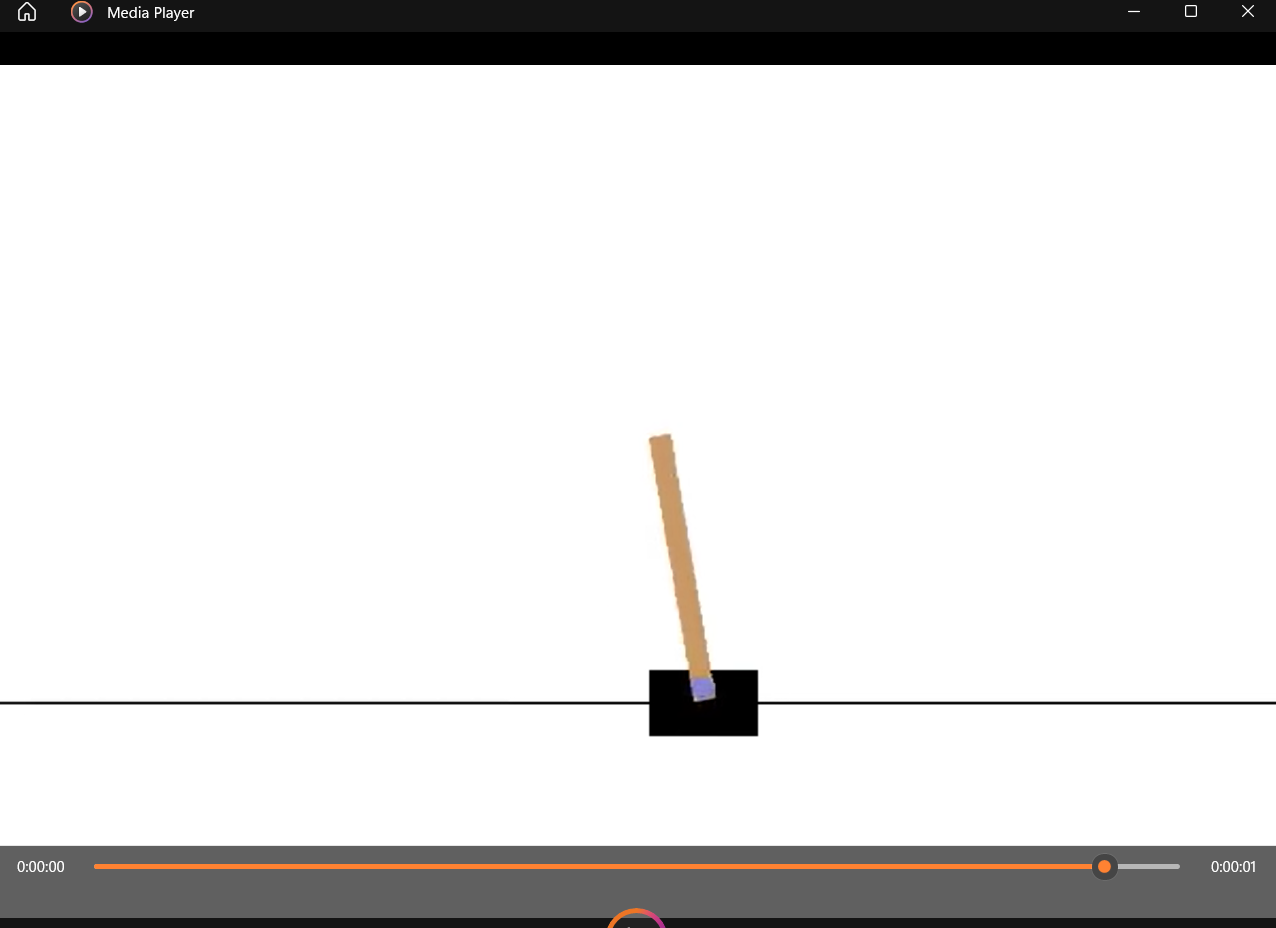

<p class="task" id="2"></p>

2\. Повторите решение задачи 1, делая шаг обучения не после одного эпизода, а по результату прогонов нескольких эпизодов. Обратите внимание, что после обновления весов модели все старые данные для обучения становятся неактуальными и должны быть удалены.

- [ ] Проверено на семинаре

In [40]:
from dataclasses import dataclass

@dataclass
class TrainConfigSeveralEpisodes:
    gamma: float = 0.99
    learning_rate: float = 0.001
    episode_num: float = 400
    n_episodes_in_epoch: int = 16

In [46]:
class TrainerSeveralEpisodes:
  def __init__(self, policy_net, train_config):
    self.policy_net = policy_net
    self.gamma = train_config.gamma
    self.learning_rate = train_config.learning_rate
    self.episode_num = train_config.episode_num
    self.n_episodes_in_epoch = train_config.n_episodes_in_epoch

  def get_episodes(self, env):
    episodes = []
    for _ in range(self.n_episodes_in_epoch):
      episode = []
      state = env.reset()[0]
      while True:
        state = torch.FloatTensor(state).to(self.policy_net.device)
        action, log_prob = self.policy_net.get_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if terminated or truncated:
          break
      episodes.append(episode)
    return episodes

  def train(self, env):
    optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
    self.episode_rewards = []

    for i in range(self.episode_num+1):
      policy_loss = 0
      episodes = self.get_episodes(env)
      for episode in episodes:
        total_reward = 0

        for t in range(len(episode)):
          state, action, reward = episode[t]
          action_taken, log_prob = self.policy_net.get_action(state)
          R = np.sum([rew * (self.gamma ** i) for i, (_,_,rew)  in enumerate(episode[t:])])
          policy_loss -= log_prob * R
          total_reward += reward
        self.episode_rewards.append(total_reward)

      optimizer.zero_grad()
      policy_loss.backward()
      optimizer.step()

      if i % 50 == 0:
        print(f'Epoch_{i}: mean reward = {np.mean(self.episode_rewards[-50:])}')

In [74]:
env = gym.make('CartPole-v1')
n_obs = env.observation_space.shape[0]
n_acts = env.action_space.n

policy_config = PolicyConfig(n_obs, n_acts, 5000)
train_config = TrainConfigSeveralEpisodes(0.99, 1e-5, 400, 50)

policy_net = PolicyNetwork(policy_config)
trainer = TrainerSeveralEpisodes(policy_net, train_config)
trainer.train(env)

Epoch_0: mean reward = 21.0
Epoch_50: mean reward = 20.54
Epoch_100: mean reward = 22.76
Epoch_150: mean reward = 24.34
Epoch_200: mean reward = 23.94
Epoch_250: mean reward = 23.7
Epoch_300: mean reward = 28.7
Epoch_350: mean reward = 23.6
Epoch_400: mean reward = 25.88


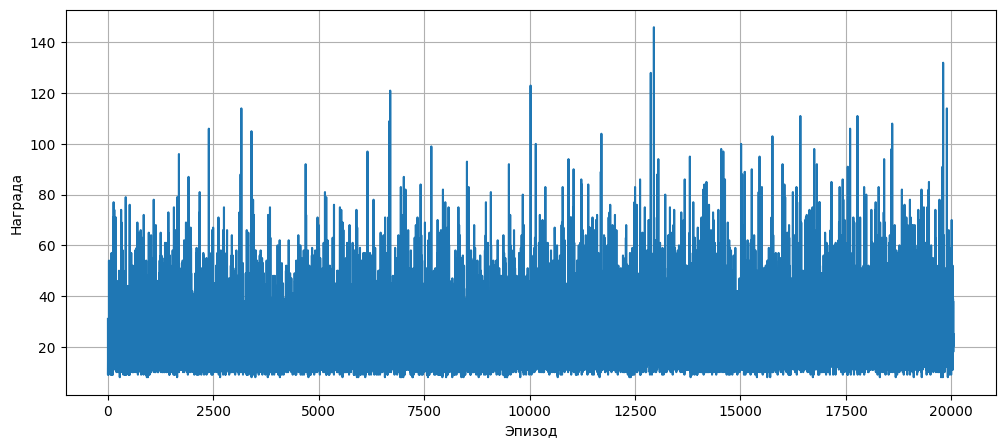

In [75]:
fig = plt.figure(figsize=(12,5))
plt.plot(trainer.episode_rewards[::])
plt.xlabel('Эпизод')
plt.ylabel('Награда')
plt.grid()

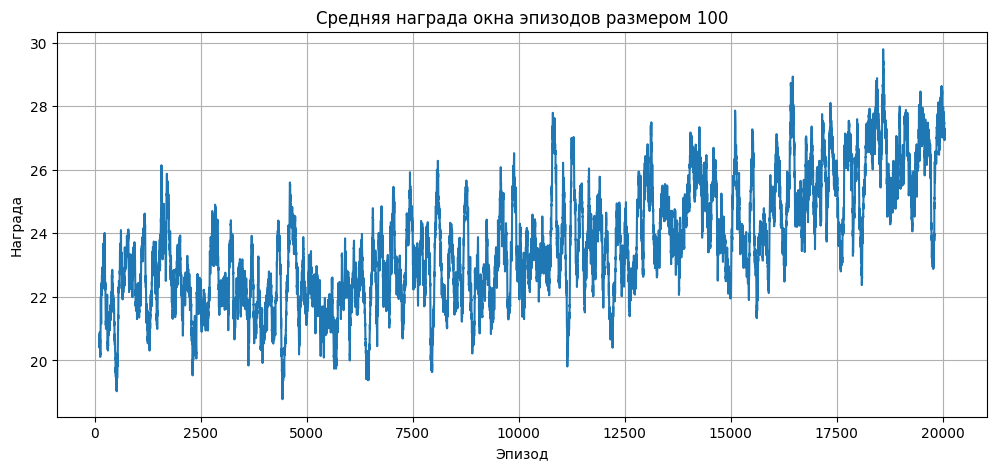

In [80]:
fig = plt.figure(figsize=(12,5))
df = pd.DataFrame(trainer.episode_rewards)

plt.title('Средняя награда окна эпизодов размером 100')
plt.plot(df.rolling(window=100).mean())
plt.xlabel('Эпизод')
plt.ylabel('Награда')
plt.grid()

In [84]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
env = wrappers.RecordVideo(env, './videos')
state = env.reset()[0]
total_reward = 0

while True:
  env.render()
  action, _ = policy_net.get_action(torch.FloatTensor(state))
  next_state, reward, terminated, truncated, _ = env.step(action)
  total_reward += reward
  state = next_state

  if terminated or truncated:
    break

print(f"Награда: {total_reward}")
env.close()

Moviepy - Building video /content/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-0.mp4
Награда: 48.0


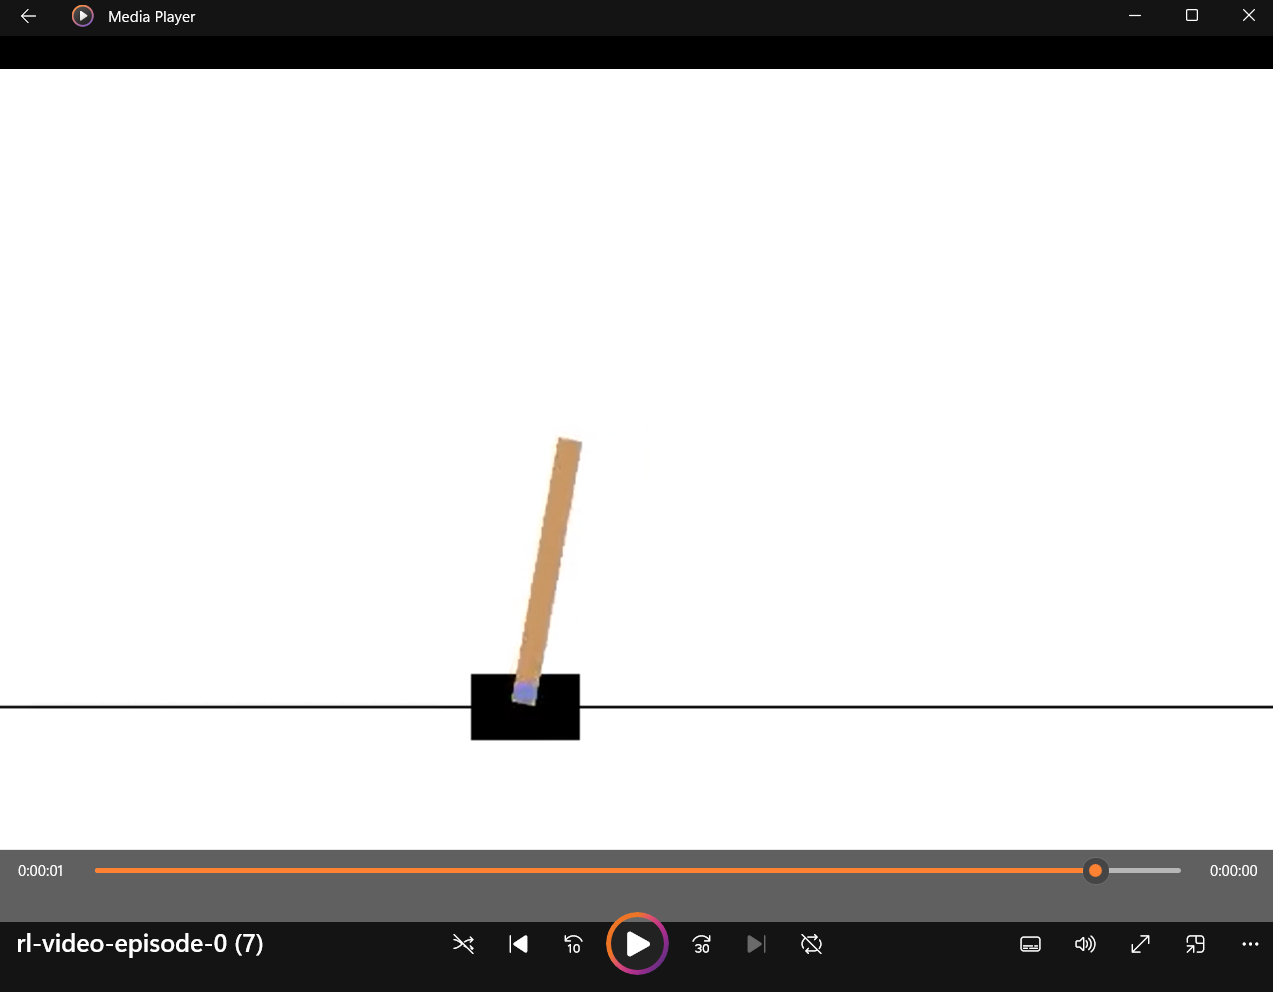

<p class="task" id="3"></p>

3\. Повторите решение задачи 1, реализовав алгоритм REINFONCE с baseline.

$$L_{PG} = -\sum_{i}{A_i\log{p(a_i|s_i)}}$$

$$A_i = R_i - V(s_i)$$

$$R_t = \sum_{k=0}^{\infty}\gamma^kr_{t+k}$$

где $r_t$ - награда за шаг $t$.

$p(a_i|s_i)$ и $V(s_i)$ моделируются при помощи двух независимых сетей. Сеть для политики настраивается аналогично задаче 1 и 2 при помощи функции потерь $L_{PG}$. Сеть для оценки базы настраивается в процессе решения задачи регрессии: $L_{V} = \sum_i(V(s_i) - R_i)^2$. Настройка весов обеих моделей происходит после каждого эпизода.

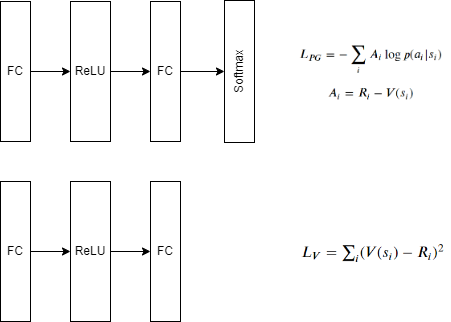

- [ ] Проверено на семинаре

In [148]:
@dataclass
class BaseConfig:
    n_state: int
    n_hidden: int

@dataclass
class TrainConfigWithBaseline:
    gamma: float = 0.99
    learning_rate: float = 0.001
    lr_base: float = 0.001
    episode_num: float = 400

In [149]:
class BaseNetwork(nn.Module):
    def __init__(self, base_config: BaseConfig):
        super().__init__()
        self.cfg = policy_config
        self.model = nn.Sequential(nn.Linear(base_config.n_state, base_config.n_hidden),
                                   nn.ReLU(),
                                   nn.Linear(base_config.n_hidden, 1))

    def forward(self, s: th.Tensor):
        return self.model(s)

In [181]:
class TrainerWithBaseline:
  def __init__(self, policy_net, base_net, train_config):
    self.policy_net = policy_net
    self.base_net = base_net
    self.gamma = train_config.gamma
    self.learning_rate = train_config.learning_rate
    self.lr_base = train_config.lr_base
    self.episode_num = train_config.episode_num

  def get_episode(self, env):
    episode = []
    state = env.reset()[0]
    while True:
      state = torch.FloatTensor(state)
      action, log_prob = self.policy_net.get_action(state)
      next_state, reward, terminated, truncated, _ = env.step(action)
      episode.append((state, action, reward))
      state = next_state
      if terminated or truncated:
        break
    return episode

  def train(self, env):
    optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
    optimizer_base = optim.Adam(self.base_net.parameters(), lr=self.lr_base)
    self.episode_rewards = []

    for i in range(self.episode_num+1):
      policy_loss = 0
      base_loss = 0
      episode = self.get_episode(env)
      total_reward = 0

      for t in range(len(episode)):
        state, action, reward = episode[t]
        state = torch.FloatTensor(state)
        action_taken, log_prob = self.policy_net.get_action(state)
        V = self.base_net(state)
        R = np.sum([rew * (self.gamma ** i) for i, (_,_,rew)  in enumerate(episode[t:])])
        policy_loss -= log_prob * (R-V.detach())
        base_loss += torch.pow(V-R, 2)
        total_reward += reward
      self.episode_rewards.append(total_reward)

      optimizer_base.zero_grad()
      base_loss.backward()
      optimizer_base.step()

      optimizer.zero_grad()
      policy_loss.backward()
      optimizer.step()

      if i % 50 == 0:
        print(f'Epoch_{i}: mean reward = {np.mean(self.episode_rewards[-50:])}')
        print(f'{base_loss.item() = }')

In [184]:
env = gym.make('CartPole-v1')
n_obs = env.observation_space.shape[0]
n_acts = env.action_space.n

policy_config = PolicyConfig(n_obs, n_acts, 3000)
base_config = BaseConfig(n_obs, 1000)
train_config = TrainConfigWithBaseline(0.99, 1e-5, 1e-4, 400)

policy_net = PolicyNetwork(policy_config)
base_net = BaseNetwork(base_config)
trainer = TrainerWithBaseline(policy_net, base_net, train_config)
trainer.train(env)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch_0: mean reward = 15.0
base_loss.item() = 1116.481201171875
Epoch_50: mean reward = 26.12
base_loss.item() = 6287.7822265625
Epoch_100: mean reward = 25.2
base_loss.item() = 9787.6630859375
Epoch_150: mean reward = 25.0
base_loss.item() = 1810.9986572265625
Epoch_200: mean reward = 31.16
base_loss.item() = 1285.5765380859375
Epoch_250: mean reward = 28.4
base_loss.item() = 10476.6923828125
Epoch_300: mean reward = 27.7
base_loss.item() = 1755.637451171875
Epoch_350: mean reward = 32.96
base_loss.item() = 15076.3837890625
Epoch_400: mean reward = 26.5
base_loss.item() = 13042.0693359375


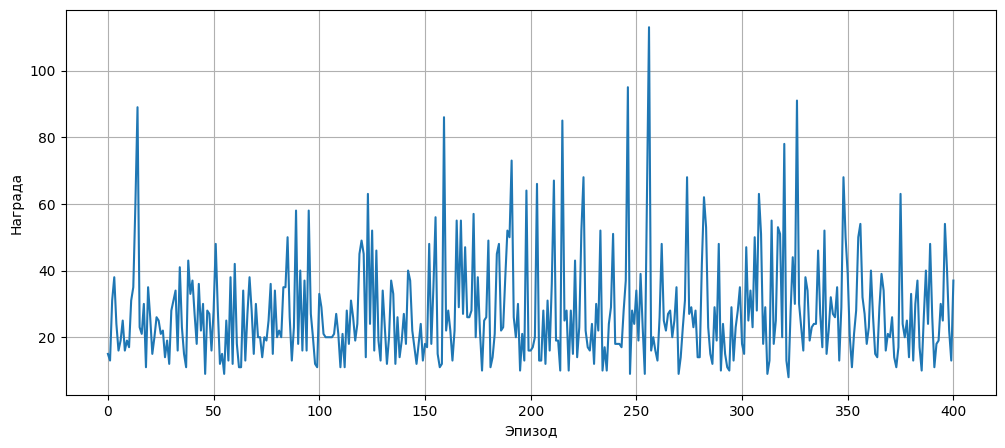

In [185]:
fig = plt.figure(figsize=(12,5))
plt.plot(trainer.episode_rewards[::])
plt.xlabel('Эпизод')
plt.ylabel('Награда')
plt.grid()

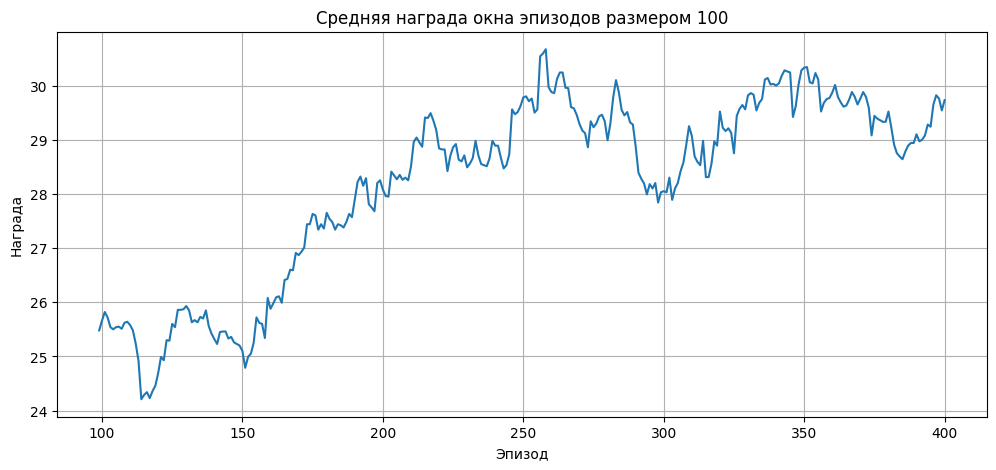

In [186]:
fig = plt.figure(figsize=(12,5))
df = pd.DataFrame(trainer.episode_rewards)

plt.title('Средняя награда окна эпизодов размером 100')
plt.plot(df.rolling(window=100).mean())
plt.xlabel('Эпизод')
plt.ylabel('Награда')
plt.grid()

In [192]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
env = wrappers.RecordVideo(env, './videos')
state = env.reset()[0]
total_reward = 0

while True:
  env.render()
  action, _ = policy_net.get_action(torch.FloatTensor(state))
  next_state, reward, terminated, truncated, _ = env.step(action)
  total_reward += reward
  state = next_state

  if terminated or truncated:
    break

print(f"Награда: {total_reward}")
env.close()

Moviepy - Building video /content/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-0.mp4
Награда: 76.0


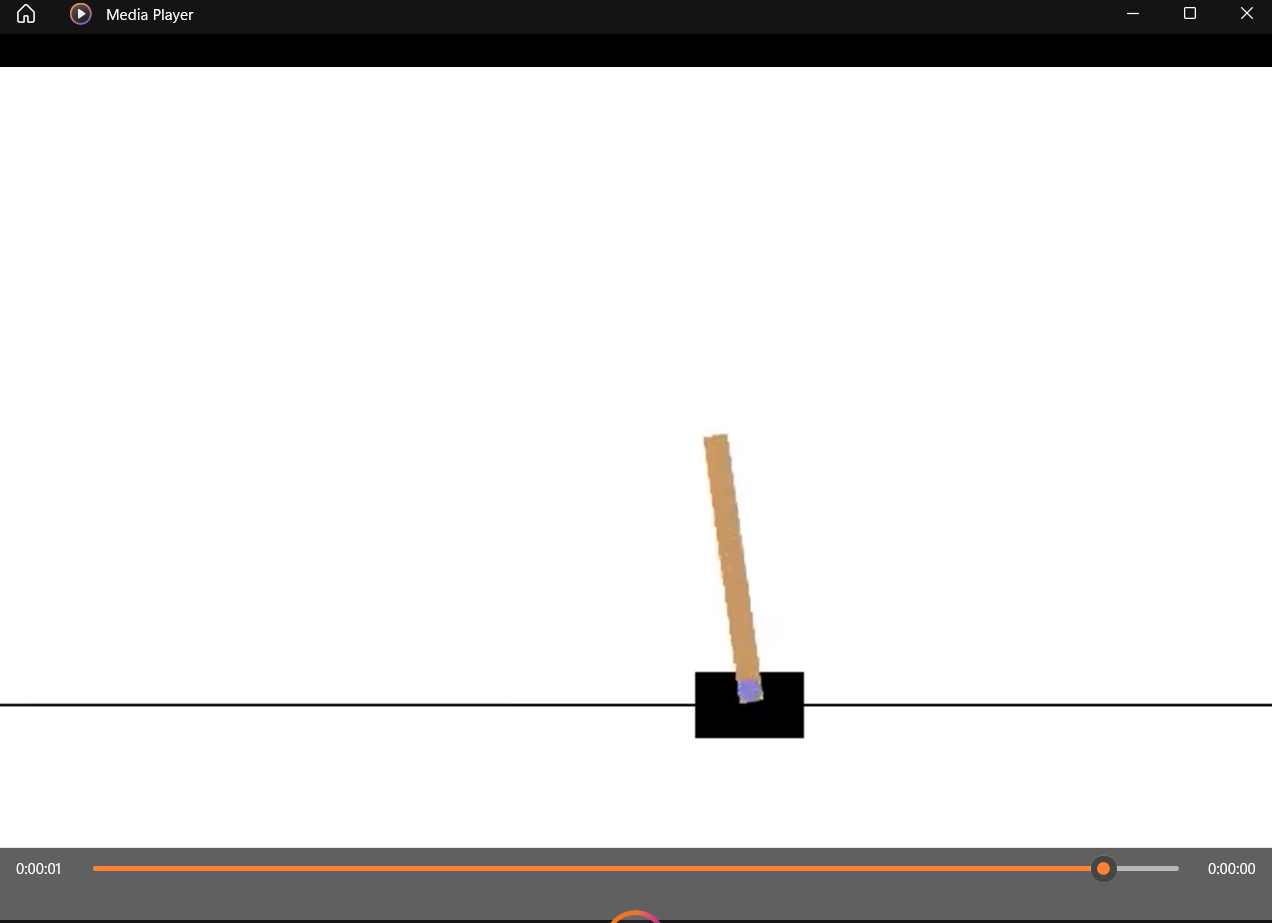

<p class="task" id="4"></p>

4\. Повторите решение задачи 1, реализовав алгоритм Actor-Critic

$$L_{PG} = -\sum_{i}{A_i\log{p(a_i|s_i)}}$$

$$A_i = R_i - V(s_i)$$

$$R_t = \sum_{k=0}^{\infty}\gamma^kr_{t+k}$$

где $r_t$ - награда за шаг $t$.

$p(a_i|s_i)$ и $V(s_i)$ моделируются при помощи одной сети в двумя головами. Голова для политики настраивается аналогично задаче 1 и 2 при помощи функции потерь $L_{PG}$. Голова для оценки базы настраивается в процессе решения задачи регрессии: $L_{V} = \sum_i(V(s_i) - R_i)^2$. Итоговая функции потерь для настройки представляет из себя сумму функций потерь для голов: $L = L_{PG} + L_{V}$.

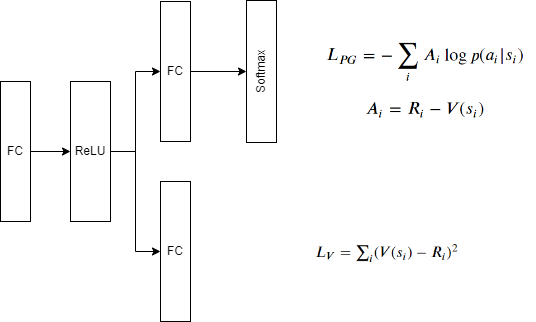

- [ ] Проверено на семинаре

In [207]:
class Policy(nn.Module):
  def __init__(self, policy_config: PolicyConfig):
    super(Policy, self).__init__()
    self.fc = nn.Linear(policy_config.n_state, policy_config.n_hidden)
    self.fc_actor = nn.Linear(policy_config.n_hidden, policy_config.n_action)
    self.fc_critic = nn.Linear(policy_config.n_hidden, 1)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim=0)

  def forward(self, x):
    x = self.relu(self.fc(x))
    probs = self.softmax(self.fc_actor(x))
    value = self.fc_critic(x)
    return probs, value

  def get_action(self, s: th.Tensor) -> tuple[int, float]:
    # возвращает действие пропорционально вероятностям, полученным при помощи модели
    # и логарифм вероятности выбранного действия
    probs, value = self.forward(s)
    action = th.multinomial(probs, 1).item()
    log_prob = probs[action].log()
    return action, log_prob, value

In [210]:
class TrainerActCr:
  def __init__(self, policy_net, train_config):
    self.policy_net = policy_net
    self.gamma = train_config.gamma
    self.learning_rate = train_config.learning_rate
    self.episode_num = train_config.episode_num

  def get_episode(self, env):
    episode = []
    state = env.reset()[0]
    while True:
      state = torch.FloatTensor(state)
      action, log_prob, value = self.policy_net.get_action(state)
      next_state, reward, terminated, truncated, _ = env.step(action)
      episode.append((state, action, reward))
      state = next_state
      if terminated or truncated:
        break
    return episode

  def train(self, env):
    optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
    self.episode_rewards = []

    for i in range(self.episode_num+1):
      policy_loss = 0
      episode = self.get_episode(env)
      total_reward = 0

      for t in range(len(episode)):
        state, action, reward = episode[t]
        state = torch.FloatTensor(state)
        action_taken, log_prob, V = self.policy_net.get_action(state)
        R = np.sum([rew * (self.gamma ** i) for i, (_,_,rew)  in enumerate(episode[t:])])
        policy_loss += torch.pow(V-R,2) - log_prob * (R-V)

        total_reward += reward
      self.episode_rewards.append(total_reward)

      optimizer.zero_grad()
      policy_loss.backward()
      optimizer.step()

      if i % 50 == 0:
        print(f'Epoch_{i}: mean reward = {np.mean(self.episode_rewards[-50:])}')

In [263]:
env = gym.make('CartPole-v1')
n_obs = env.observation_space.shape[0]
n_acts = env.action_space.n

policy_config = PolicyConfig(n_obs, n_acts, 300)
train_config = TrainConfig(0.99, 1e-5, 10000)

policy_net = Policy(policy_config)
trainer = TrainerActCr(policy_net, train_config)
trainer.train(env)

Epoch_0: mean reward = 17.0
Epoch_50: mean reward = 25.84
Epoch_100: mean reward = 22.0
Epoch_150: mean reward = 24.68
Epoch_200: mean reward = 22.36
Epoch_250: mean reward = 22.78
Epoch_300: mean reward = 22.54
Epoch_350: mean reward = 24.3
Epoch_400: mean reward = 25.28
Epoch_450: mean reward = 22.04
Epoch_500: mean reward = 24.64
Epoch_550: mean reward = 20.48
Epoch_600: mean reward = 25.46
Epoch_650: mean reward = 18.78
Epoch_700: mean reward = 21.16
Epoch_750: mean reward = 24.58
Epoch_800: mean reward = 24.44
Epoch_850: mean reward = 24.54
Epoch_900: mean reward = 25.0
Epoch_950: mean reward = 22.48
Epoch_1000: mean reward = 21.48
Epoch_1050: mean reward = 21.36
Epoch_1100: mean reward = 22.3
Epoch_1150: mean reward = 21.24
Epoch_1200: mean reward = 25.9
Epoch_1250: mean reward = 23.62
Epoch_1300: mean reward = 25.72
Epoch_1350: mean reward = 23.56
Epoch_1400: mean reward = 21.28
Epoch_1450: mean reward = 27.48
Epoch_1500: mean reward = 25.62
Epoch_1550: mean reward = 25.04
Epoch

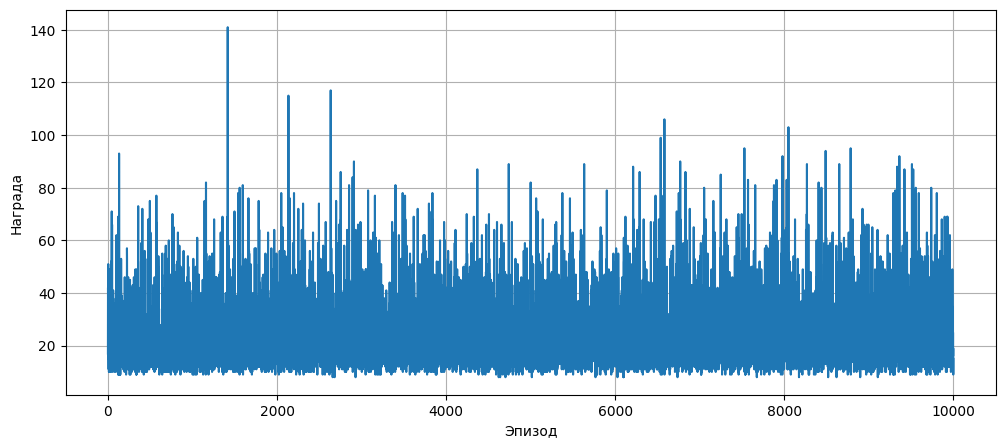

In [264]:
fig = plt.figure(figsize=(12,5))
plt.plot(trainer.episode_rewards[::])
plt.xlabel('Эпизод')
plt.ylabel('Награда')
plt.grid()

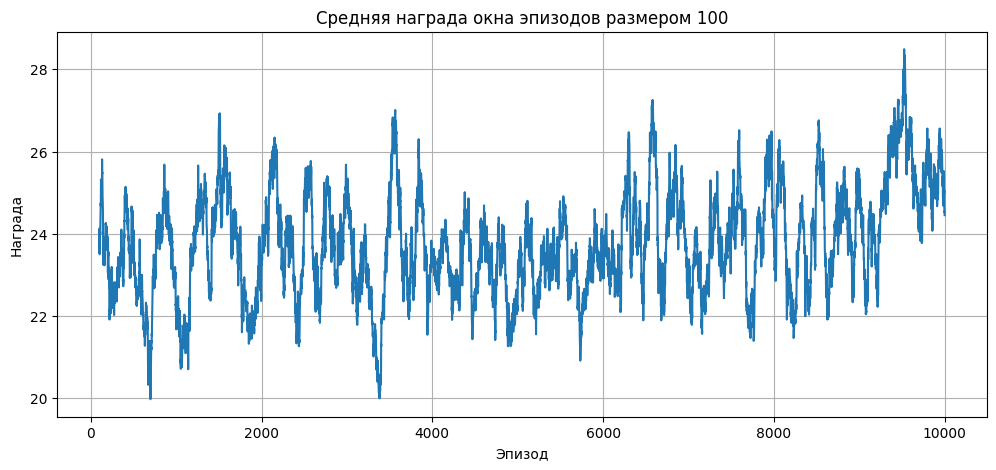

In [265]:
fig = plt.figure(figsize=(12,5))
df = pd.DataFrame(trainer.episode_rewards)

plt.title('Средняя награда окна эпизодов размером 100')
plt.plot(df.rolling(window=100).mean())
plt.xlabel('Эпизод')
plt.ylabel('Награда')
plt.grid()

In [276]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
env = wrappers.RecordVideo(env, './videos')
state = env.reset()[0]
total_reward = 0

while True:
  env.render()
  action, _, _ = policy_net.get_action(torch.FloatTensor(state))
  next_state, reward, terminated, truncated, _ = env.step(action)
  total_reward += reward
  state = next_state

  if terminated or truncated:
    break

print(f"Награда: {total_reward}")
env.close()

Moviepy - Building video /content/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-0.mp4
Награда: 86.0


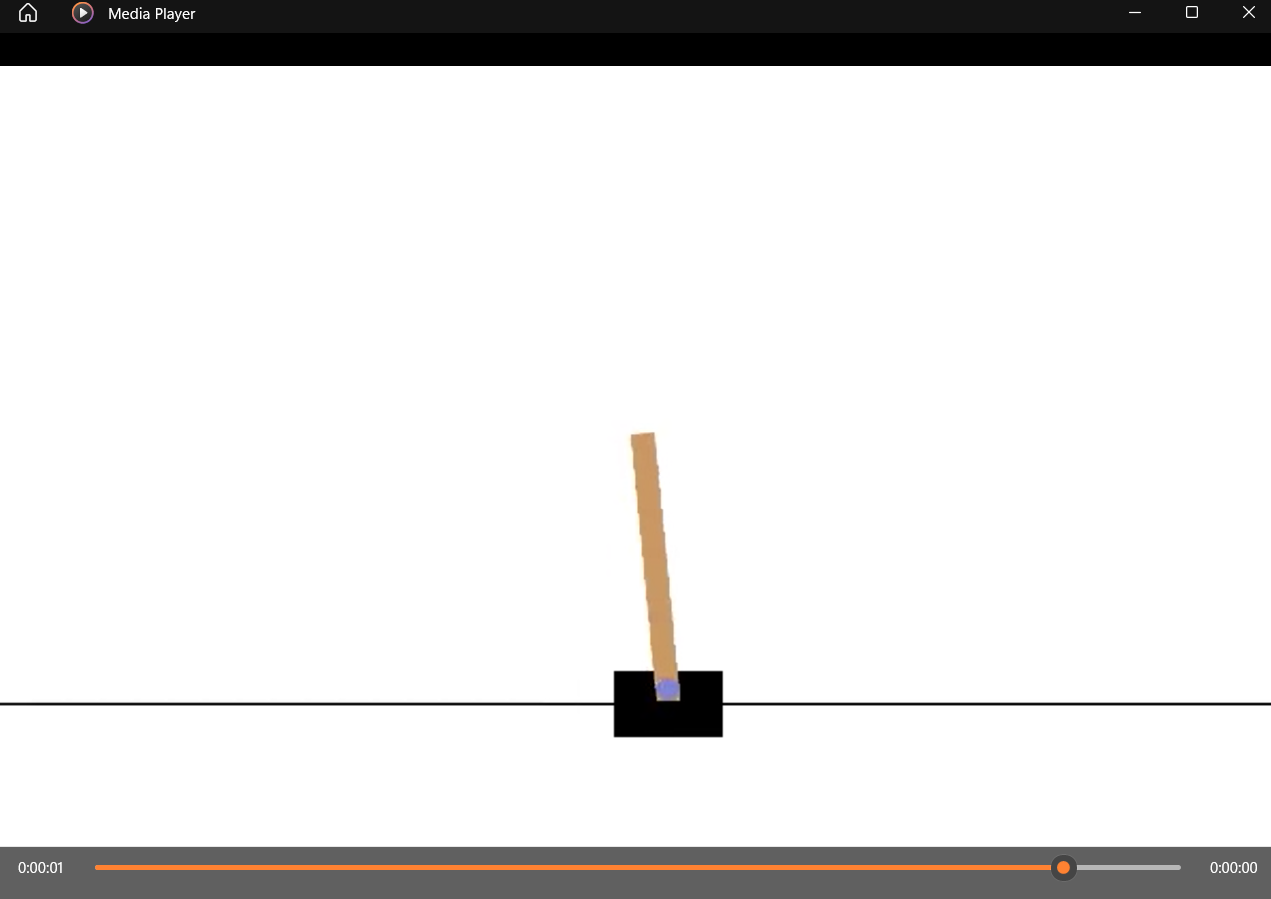

## Обратная связь
- [ ] Хочу получить обратную связь по решению